# Introduction

Here we show a fully differentiable propostional reasoning system. We demonstrate that the system captures the inherent structure in propositional reasoning by using a dataset with consistent and inconsistent formulae. The goal in this task is to build a classifier for classifying sets of formulae which are consistent or inconsistent.


## Architecture

The figure below shows one step in the reasoning process. We start with an initial set of formulae encoded in the workspace. Then we select a formula $f_1$ by applying a transformation parametrized by $W$. We then have to change the workspace to account for this selection. We do so by applying a different transformation to the workspace parametrized by $A$. We then repeat the transformation parametrized by $W$ to get another formula $f_2$.  We combine the two formula in a step that is parametrized by $C$. We finally incorporate the new formula in the workspace using $A$.

![title](onestep.png)


## Experiment

In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("./train",header=None, names= ["id","c1","c2","c3", "c4"])

In [3]:
test = pd.read_csv("./test",header=None, names= ["id","c1","c2","c3", "c4"])

In [4]:
def getProblem(id):
    problemChunk = train[train["id"]== ("P" + str(id))][["c1", "c2", "c3", "c4"]]
    return (problemChunk[0:len(problemChunk)-1].values.astype(float), problemChunk["c4"].values[4])
  
def getTestProblem(id):
    problemChunk = test[test["id"]== ("P" + str(id))][["c1", "c2", "c3", "c4"]]
    return (problemChunk[0:len(problemChunk)-1].values.astype(float), problemChunk["c4"].values[4])
    

In [5]:
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2.) + 1)

def reason(formulae, weights):
    W = weights[0:4,:]
    A = weights[4:8,:]
    C = weights[8:12,:]
    for d in range(0, 5):
        f1 = np.matmul(formulae, W)
        formulae = np.add(formulae, np.dot(A, f1))
        f2 = np.matmul(formulae, W)
        formulae = np.add(formulae, np.dot(A, f2))
        c = sigmoid(np.add(f2, np.dot(f1, C)))
        formulae = np.add(formulae, np.dot(A, c))
    return sigmoid(np.log(np.linalg.norm(formulae)))
    
    

In [6]:
W = np.random.randn(4,4)
A = np.random.randn(4,4)
C = np.random.randn(4,4)

In [7]:
weights = np.vstack([W, A, C])

In [8]:
def training_loss(weights):
    sumT = 0
    # Training loss is the negative log-likelihood of the training labels.
    for i in range(0, 100):
        problem = getProblem(np.random.randint(0,1000))
        target = problem[1]
        formulae = problem[0]
        pred = reason(formulae, weights)

        sumT = sumT  - np.log(pred * target + (1 - pred) * (1 - target))
        
    return sumT/100


In [9]:
def perf(weights):
    sumT = 0
    # Training loss is the negative log-likelihood of the training labels.
    for i in range(0, 1000):
        problem = getTestProblem(i)
        target = problem[1]
        formulae = problem[0]
        pred = reason(formulae, weights)

        sumT = sumT  - np.log(pred * target + (1 - pred) * (1 - target))
        
    return sumT/1000

In [10]:
training_gradient_fun = grad(training_loss)

In [11]:
print("Initial loss:", training_loss(weights))

Initial loss: 0.424700991254


In [12]:
perf_losses = np.zeros(100)
for i in range(100):    
    weights -= training_gradient_fun(weights) * 0.20* (1 - i/100)
    perf_losses[i] = perf(weights)

In [13]:
print("Trained loss:", training_loss(weights))

Trained loss: 0.168986659369


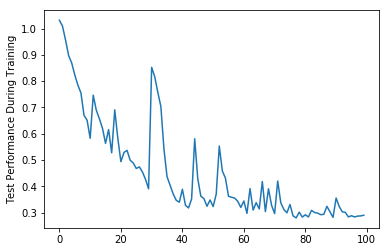

In [14]:
plt.plot(perf_losses)
plt.ylabel('Test Performance During Training')
plt.show()


In [15]:
perf(weights)

0.29027037048925869

In [45]:
def randomPerf():
    sumT = 0
    "What is the performance if we always chose the majority label"
    for i in range(0, 1000):
        problem = getTestProblem(i)
        target = problem[1]
        pred = 1-np.finfo(np.float32).eps

        sumT = sumT  - np.log(pred * target + (1 - pred) * (1 - target))
        
    return sumT/1000

In [46]:
groundPerf()

1.1797366117008301